## Раздел 0. Стартовые нюансы проекта

### Краткое описание проекта

**Проект:** Система мониторинга открытого огня 

**Автор проекта:** Гуленко Дмитрий Александрович, студент 1-го курса магистратуры факультета ИИКС, направления "Машинное обучение"

**Краткое описание проекта:** Система мониторинга открытого огня и людей в зонах барбекю или иных зонах, связанных с приотовлением пищи на природе. Данная система призвана быть полезной егерям или смотрителям парков для поддержания порядка и предупреждения лесных пожаров, вызванных антропогенными факторами. Сейчас представляется MVP модели, которая определяет огонь и людей. 

### Чек-лист проверки соответствия некоторых требований PEP8

- Добавлена докстринга с описанием проекта
- Константы в верхнем регистре (IMAGE_DATA)
- Логические разделы с четкими комментариями
- Перенос длинных строк (максимум 79 символов)
- Пробелы вокруг операторов для лучшей читаемости
- Единый стиль именования переменных и функций
- Подробные комментарии к каждому блоку кода
- Логическая группировка импортов

### Установка нужных библиотек и зависимостей

In [ ]:
# Для установки требуется Python версии не старше 3.12.0

pip install inference-sdk # Выполняется один раз

### Импорт необходимых библиотек

In [34]:
import supervision as sv  # Для работы с детекциями и аннотациями
import numpy as np  # Для работы с массивами и математических операций
import requests  # Для HTTP-запросов к удаленным ресурсам
from PIL import Image  # Для работы с изображениями
from io import BytesIO  # Для работы с байтовыми потоками в памяти
import matplotlib.pyplot as plt  # Для визуализации результатов
from collections import Counter  # Для подсчета частоты элементов
from inference_sdk import InferenceHTTPClient  # Клиент для работы с Roboflow API

### Раздел 1. Подготовка данных.

In [35]:
# Указание на тестовое изображение с огнем
# Предполагается, что в реальной жизни - это будет поток кадров 
# с камер видеонаблюдения 

# URL тестового файла для демонстрации работы MVP
IMAGE_DATA = 'https://img.freepik.com/free-photo/burning-campfire-sandy-beach-sunset-generated-by-ai_188544-42455.jpg?semt=ais_hybrid&w=740'

### Раздел 2. Создание клиента в Roboflow

In [36]:
"""
Настройка клиента для взаимодействия с Roboflow Inference API.
Используется серверная часть Roboflow для выполнения предсказаний.
"""

# Инициализация клиента Roboflow Inference
client = InferenceHTTPClient(
    api_url="https://serverless.roboflow.com",  # Endpoint API
    api_key="burBtmjlGvZ7rvsWiQLj"  # API ключ для аутентификации
)

## Раздел 3.Выполнение предсказания (определение огня)

In [37]:
"""
Отправка изображения на анализ в предобученную модель через workflow.
Workflow "find-fires-bbq" определяет огонь, людей и мангалы на изображении.
"""

# Выполнение инференса через предопределенный workflow
result = client.run_workflow(
    workspace_name="projects-mephi",  # Рабочее пространство в Roboflow
    workflow_id="find-fires-bbq-with-fires-humans-and-bbqs",  # ID workflow
    images={"image": IMAGE_DATA},  # Изображение для анализа
    use_cache=True  # Использование кэша для ускорения повторных запросов
)

## Раздел 4. Конвертация изображения + загрузка

In [38]:
"""
Загрузка исходного изображения из интернета и преобразование в формат,
подходящий для обработки и визуализации.
"""

# Загрузка изображения по URL
response = requests.get(IMAGE_DATA)
# Преобразование байтов в объект Image и конвертация в RGB
image = Image.open(BytesIO(response.content)).convert('RGB')
# Конвертация в numpy array для совместимости с библиотеками компьютерного зрения
image_np = np.array(image)

## Раздел 5. Обработка результатов

In [39]:
"""
Преобразование сырых предсказаний от API в структурированный формат Detections
для дальнейшей обработки и визуализации.
"""

# Извлечение данных предсказаний из результата
prediction_data = result[0]
# Создание объекта Detections из предсказаний Roboflow
detections = sv.Detections.from_inference(prediction_data['predictions'])

## Раздел 6. Подготовка к визуализации

In [40]:
"""
Настройка инструментов для аннотации изображения: bounding boxes и текстовых меток.
Создание читаемых меток с именами классов и уровнями уверенности.
"""

# Инициализация аннотатора для bounding boxes
box_annotator = sv.BoxAnnotator()
# Инициализация аннотатора для текстовых меток
label_annotator = sv.LabelAnnotator()

# Создание форматированных меток для каждого обнаруженного объекта
# Формат: "имя_класса уверенность"
labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence 
    in zip(detections.data["class_name"], detections.confidence)
]

## Раздел 7. Отрисовка на изображении

In [41]:
"""
Добавление визуальных аннотаций на изображение: сначала bounding boxes,
затем текстовые метки. Используется копия изображения для сохранения оригинала.
"""

# Аннотация bounding boxes на копии изображения
annotated_image = box_annotator.annotate(
    scene=image_np.copy(),
    detections=detections
)

# Добавление текстовых меток поверх bounding boxes
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=labels
)

## Раздел 8. Вывод результатов и финальная визуализация

ОПАСНОСТЬ! Обнаружен открытый огонь. Рядом с огнем 9 человек.


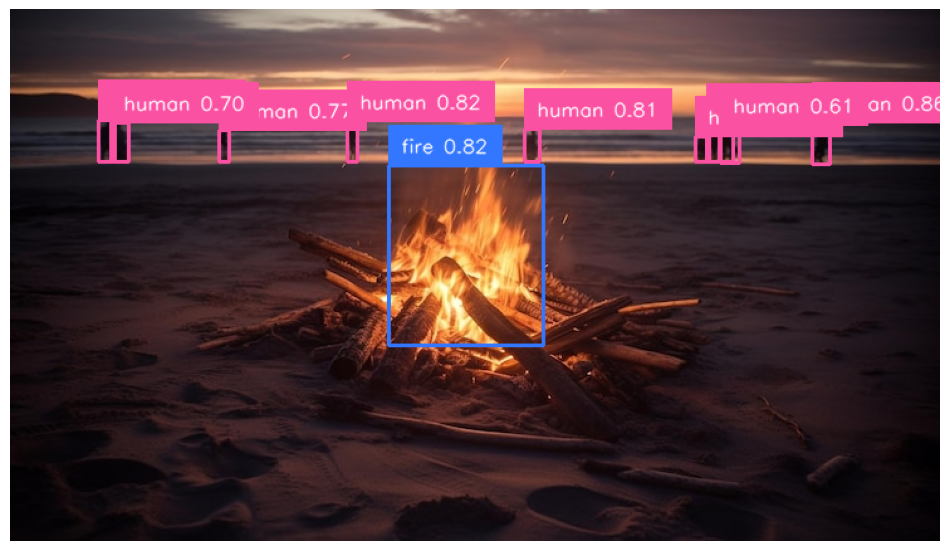

In [ ]:
"""
РАЗДЕЛ 8: АНАЛИЗ И ВЫВОД РЕЗУЛЬТАТОВ С ВИЗУАЛИЗАЦИЕЙ

ОПИСАНИЕ СЦЕНАРИЕВ:
1. Огонь и люди -> проверка расстояния -> сообщение о безопасности
2. Только огонь -> сообщение об огне без людей
3. Только люди -> подсчет и сообщение о количестве людей
4. Другие объекты -> определение самого частого класса
5. Ничего не обнаружено

КЛЮЧЕВЫЕ ПЕРЕМЕННЫЕ:
- total_count: общее количество обнаруженных объектов
- class_names: список названий всех обнаруженных классов
- boxes: координаты bounding boxes объектов (xyxy формат)
- has_fire: флаг наличия огня на изображении
- has_people: флаг наличия людей на изображении
- fire_indices: индексы объектов типа "огонь" в массиве детекций
- people_indices: индексы объектов типа "человек" в массиве детекций
- people_near_fire: счетчик людей, находящихся близко к огню
- person_center/fire_center: координаты центров bounding boxes
- distance: евклидово расстояние между человеком и огнем
- output_message: финальное текстовое сообщение о ситуации
- annotated_image: изображение с нарисованными bounding boxes и метками
"""

total_count = len(detections)

if total_count > 0:
    class_names = detections.data["class_name"]
    boxes = detections.xyxy
    
    has_fire = any('fire' in name.lower() for name in class_names)
    has_people = any('human' in name.lower() or 'person' in name.lower() or 'man' in name.lower() for name in class_names)
    
    if has_fire and has_people:
        fire_indices = [i for i, name in enumerate(class_names) if 'fire' in name.lower()]
        people_indices = [i for i, name in enumerate(class_names) if any(word in name.lower() for word in ['human', 'person', 'man'])]
        
        people_near_fire = 0
        
        for p_idx in people_indices:
            person_box = boxes[p_idx]
            person_center = ((person_box[0] + person_box[2]) / 2, (person_box[1] + person_box[3]) / 2)
            
            for f_idx in fire_indices:
                fire_box = boxes[f_idx]
                fire_center = ((fire_box[0] + fire_box[2]) / 2, (fire_box[1] + fire_box[3]) / 2)
                
                distance = ((person_center[0] - fire_center[0])**2 + (person_center[1] - fire_center[1])**2)**0.5
                
                if distance < 300:
                    people_near_fire += 1
                    break
        
        if people_near_fire > 0:
            output_message = f"ОПАСНОСТЬ! Обнаружен открытый огонь. Рядом с огнем {people_near_fire} человек."
        else:
            output_message = "Обнаружен открытый огонь, но люди находятся на безопасном расстоянии."
    
    elif has_fire:
        output_message = "Обнаружен открытый огонь. Людей рядом нет."
    
    elif has_people:
        people_count = sum(1 for name in class_names if any(word in name.lower() for word in ['human', 'person', 'man']))
        output_message = f"Люди обнаружены: {people_count} человек. Открытого огня нет."
    
    else:
        most_common_class = Counter(class_names).most_common(1)[0][0]
        other_count = len(class_names)
        output_message = f"Обнаружены объекты: {most_common_class} в количестве {other_count}. Людей и огня нет."

else:
    output_message = "Ничего не обнаружено: нет ни огня, ни людей."

print(output_message)

plt.figure(figsize=(12, 12))
plt.imshow(annotated_image)
plt.axis('off')
plt.show()